In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import time 
import os
import math
from ParseJsons import check_box
from multiprocessing import Process
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from geopandas.geoseries import Point
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.dpi'] = 100
% matplotlib inline


# PARSING DATA FOR REGRESSION

### Get success targets

In [2]:
city        = 'london'
outfolder   = '../ProcessedData/' + city + '/'
successdata = outfolder + 'venues_info/' + city + '_venues_success_measures.csv'
success     = pd.read_csv(successdata, sep = '\t', index_col = 0)

success.head()

,checkinsCount,tipCount,usersCount
4a5f9446f964a520e0bf1fe3,2500.0,75.0,1831.0
4abcec53f964a520b98720e3,1550.0,17.0,913.0
4abdc1c7f964a5206d8b20e3,5573.0,47.0,2777.0
4abe4502f964a520558c20e3,97190.0,575.0,80793.0
4abe5714f964a520d68c20e3,1507.0,54.0,1256.0


### Get success features

In [3]:
# basic stats of wards: bbox, length, area

outfolder    = '../ProcessedData/' + city + '/'
ward_stats_f = outfolder + 'venues_info/venues_ward_full.dat'
ward_stats   = pd.read_csv(ward_stats_f, sep = '\t', index_col = 0).drop(['ward'], axis=1)
ward_stats.head()

,lng,lat,lng0,lat0,lng1,lat1,length,area
venue,,,,,,,,
4e4cee5f52b1075a63909062,-0.083360,51.527020,-0.089691,51.519814,-0.075719,51.537491,0.066680,0.000133
4c0be1a86071a59370e5e132,-0.140126,51.516108,-0.158366,51.501861,-0.128997,51.520817,0.085100,0.000259
4c150c047f7f2d7f55c3e168,0.080118,51.527104,0.040798,51.504768,0.099798,51.527633,0.148061,0.000810
4e5ccf5eb99390f45c01d2be,0.016753,51.404104,-0.007692,51.391861,0.038852,51.418558,0.164132,0.000480
4ea94f3bbe7b84804c354799,-0.105192,51.514147,-0.109653,51.508409,-0.097070,51.517778,0.047694,0.000046


In [4]:
# category stats of wards: number of venues, fraction of food, nightlife..., entropy

ward_cats_f  = outfolder + 'venues_info/' + city + '_WARD_category_stats.csv'
ward_cats    = pd.read_csv(ward_cats_f, sep = '\t', index_col = 0).drop(['ward'], axis=1)
ward_cats.head()

,building,food,na,travel,Venues_num,parks_outdoors,Entropy,nightlife,shops,education,event,arts_entertainment
4a5f9446f964a520e0bf1fe3,0.171141,0.285235,0.010067,0.187919,298,0.043624,0.809398,0.053691,0.171141,0.050336,0.000000,0.026846
4abcec53f964a520b98720e3,0.202808,0.304086,0.009276,0.072700,3989,0.044372,0.827671,0.082477,0.166458,0.018551,0.014039,0.085234
4abdc1c7f964a5206d8b20e3,0.314685,0.255245,0.016317,0.038462,858,0.031469,0.781751,0.079254,0.181818,0.037296,0.003497,0.041958
4abe4502f964a520558c20e3,0.202808,0.304086,0.009276,0.072700,3989,0.044372,0.827671,0.082477,0.166458,0.018551,0.014039,0.085234
4abe5714f964a520d68c20e3,0.198785,0.275632,0.016271,0.053127,5101,0.012743,0.770674,0.086062,0.273868,0.008234,0.005489,0.069790


In [5]:
# venue similarity network stuff with threshold (1000 for now) 
# and
# user friendship network measures aggregated on the venue level

network_meas_f  = outfolder + '/networks/' + city + '_COMBINED_networkmeasures.csv'
network_meas    = pd.read_csv(network_meas_f, sep = ',', index_col = 0).replace([np.inf, -np.inf], np.nan).fillna(0.0)
network_meas.head()

,degree_entropy,egosize_std,eigenvector_geo_entropy,betweenness_avg,constraint_geo_avg,egosize_entropy,eigenvector_std,strength_geo_entropy,constraint_avg,eigenvector_entropy,...,degree_avg,geo_size_of_ego_std,egosize_avg,geo_stdev_of_ego_entropy,geo_size_of_ego_entropy,clustering_avg,constraint_geo_std,strength_geo_avg,eigenvector_geo_avg,clustering_geo_avg
4a5f9446f964a520e0bf1fe3,2.870691,17.817247,1.959647,86121.899119,0.390994,3.031483,0.034951,2.911981,0.352640,1.657756,...,20.894737,0.000015,13.578947,3.050401,3.637586,0.042713,0.313148,50.770749,0.003763,0.115633
4abcec53f964a520b98720e3,2.505504,23.880344,2.156664,265011.029647,0.309632,2.629491,0.066467,2.588504,0.258660,1.983019,...,32.875000,0.000015,19.750000,2.752310,3.178054,0.030472,0.293163,77.153843,0.007905,0.085077
4abdc1c7f964a5206d8b20e3,4.136376,28.479270,3.165466,201303.831079,0.320990,4.219250,0.107743,4.054566,0.273741,3.199299,...,31.472868,0.000015,19.031008,4.387062,4.859812,0.045808,0.296599,76.963997,0.010914,0.139903
4abe4502f964a520558c20e3,5.726454,20.679810,4.097569,111172.447600,0.461307,5.924366,0.063458,5.541236,0.412853,4.551911,...,17.767263,0.000015,11.453964,6.110001,6.661855,0.052769,0.333665,45.465823,0.008797,0.138118
4abe5714f964a520d68c20e3,3.437373,13.980069,2.077558,125308.749720,0.431582,3.563904,0.040449,3.381245,0.384001,2.540300,...,20.344828,0.000031,12.379310,3.581728,4.060443,0.065533,0.340734,45.807375,0.010647,0.179408


In [6]:
### full feature set

#print network_meas.head()
#print ward_cats.head()
#print ward_stats.head()

temp = network_meas.join(ward_cats)
venue_features = temp.join(ward_stats)

venue_features.head()

,degree_entropy,egosize_std,eigenvector_geo_entropy,betweenness_avg,constraint_geo_avg,egosize_entropy,eigenvector_std,strength_geo_entropy,constraint_avg,eigenvector_entropy,...,event,arts_entertainment,lng,lat,lng0,lat0,lng1,lat1,length,area
4a5f9446f964a520e0bf1fe3,2.870691,17.817247,1.959647,86121.899119,0.390994,3.031483,0.034951,2.911981,0.352640,1.657756,...,0.000000,0.026846,-0.182761,51.494744,-0.191170,51.487101,-0.171678,51.495433,0.046983,0.000080
4abcec53f964a520b98720e3,2.505504,23.880344,2.156664,265011.029647,0.309632,2.629491,0.066467,2.588504,0.258660,1.983019,...,0.014039,0.085234,-0.131414,51.508207,-0.151685,51.493703,-0.111102,51.516040,0.111045,0.000449
4abdc1c7f964a5206d8b20e3,4.136376,28.479270,3.165466,201303.831079,0.320990,4.219250,0.107743,4.054566,0.273741,3.199299,...,0.003497,0.041958,-0.105242,51.523150,-0.119896,51.518541,-0.100129,51.531899,0.062448,0.000121
4abe4502f964a520558c20e3,5.726454,20.679810,4.097569,111172.447600,0.461307,5.924366,0.063458,5.541236,0.412853,4.551911,...,0.014039,0.085234,-0.141144,51.501838,-0.151685,51.493703,-0.111102,51.516040,0.111045,0.000449
4abe5714f964a520d68c20e3,3.437373,13.980069,2.077558,125308.749720,0.431582,3.563904,0.040449,3.381245,0.384001,2.540300,...,0.005489,0.069790,-0.130879,51.514157,-0.158366,51.501861,-0.128997,51.520817,0.085100,0.000259


### Drop shitty features

In [7]:
# dropping weak features keeping good ones
ok_feats = ['closeness_entropy', 'social_stretch_entropy', 'egosize_entropy', 'geo_size_of_ego_entropy', 'pagerank_geo_entropy', 'closeness_geo_entropy', 'lng', 'lat', 'constraint_std', 'constraint_geo_entropy', 'constraint_entropy', 'degree_entropy', 'constraint_geo_std']

filtered_features = pd.DataFrame()
for feat in ok_feats:
    filtered_features[feat] = venue_features[feat]
    
print len(filtered_features.keys())


# dropping zeros
filtered_features.head()

print len(filtered_features['closeness_entropy'])


for feat in ok_feats:
    filtered_features = filtered_features[filtered_features[feat] != 0.0]    


print len(filtered_features['closeness_entropy'])


13
64508
30512


# REGRESSION CODE

In [21]:
# preproc the features

X_head = filtered_features.keys()
X      = filtered_features.values
X      = StandardScaler().fit_transform(X)
X      = preprocessing.quantile_transform(X, output_distribution = 'normal')

(array([2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        5.000e+00, 2.300e+01, 5.500e+01, 6.400e+01, 1.690e+02, 2.880e+02,
        4.510e+02, 7.900e+02, 1.148e+03, 1.570e+03, 2.119e+03, 2.489e+03,
        2.977e+03, 3.103e+03, 3.123e+03, 2.941e+03, 2.552e+03, 2.086e+03,
        1.604e+03, 1.143e+03, 7.580e+02, 4.790e+02, 2.780e+02, 1.510e+02,
        8.000e+01, 3.800e+01, 2.000e+01, 3.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-5.19933758e+00, -4.93937070e+00, -4.67940382e+00, -4.41943695e+00,
        -4.15947007e+00, -3.89950319e+00, -3.63953631e+00, -3.37956943e+00,
        -3.11960255e+00, -2.85963567e+00, -2.59966879e+00, -2.33970191e+00,
        -2.07973503e+00, -1.81976815e+00, -1.55980127e+00, -1.29983440e+00,
        -1.03986752e+00, -7.79900637e-01, -5.19933758e-01, -2.59966879e-01,
         4.89217555e-11,  2.59966879e-01,  5.19933758e-01,  7.79900637e-01,
         1.03986752e+00,  1.29983440e+00,  1.5

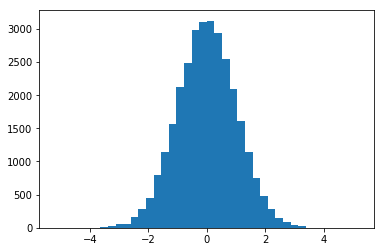

In [18]:
# preproc the target
success_t = success.reset_index()
success_t = success_t[success_t['index'].isin(list(filtered_features.index)) ]

y = np.asarray(success_t['checkinsCount'])
y = StandardScaler().fit_transform(y.reshape(-1, 1) )
y = preprocessing.quantile_transform(y, output_distribution = 'normal')

plt.hist(y, bins = 40)

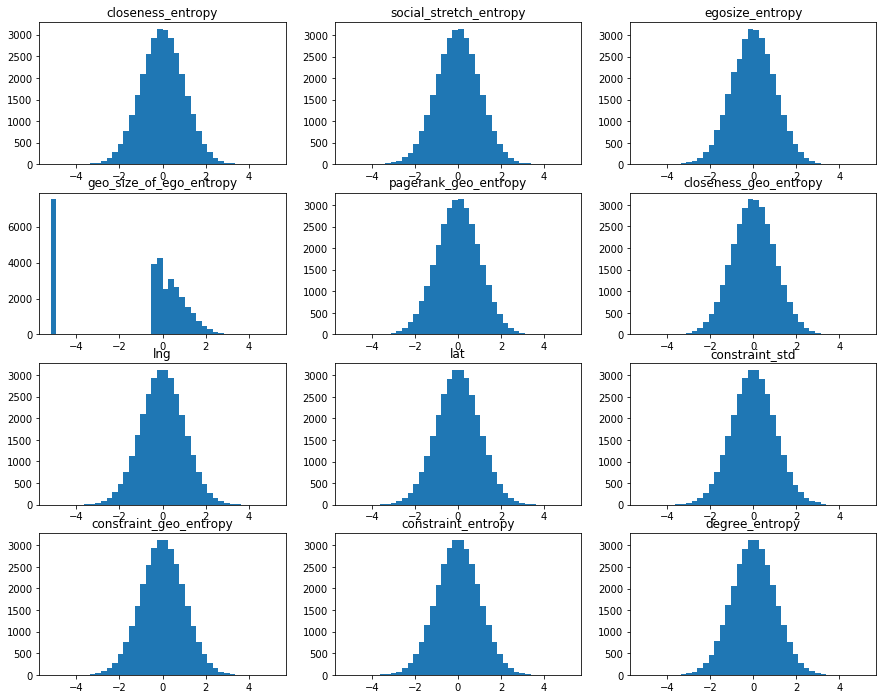

In [22]:

fig, axes = plt.subplots(4, 3, figsize=(15, 12))
for i, ax in enumerate(axes.ravel()):
    if i > 75:
        ax.set_visible(False)
        continue
    ax.hist(X[:,i], bins = 40)
    #ax.plot(X_sc[:, i], y, 'o', alpha=.05)
    ax.set_title(X_head[i])

## Linear Regression


*** https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/ ***

In [27]:
from sklearn import linear_model
from scipy import stats

class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics and p-values for model coefficients (betas).
    Additional attributes available after .fit() are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs) This class sets the intercept to 0 by default, since usually we include it  in X.
    """
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True,
                 n_jobs=1):
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.n_jobs = n_jobs

    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)
        
        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        
        #print sse
        se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])
        #se  = np.array([np.sqrt(np.diagonal(sse[i] * np.linalg.inv(np.dot(X.T, X)))) for i in range(sse.shape[0])])

        self.t = self.coef_ / se
        self.p = 2 * (1 - stats.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1]))
        return self

In [24]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

In [25]:
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

In [28]:
# Create linear regression object
linear_regressor = LinearRegression()

# Train the model using the training sets
res = linear_regressor.fit(X_train, y_train)

# The coefficients

#print('Coefficients: \n', linear_regressor.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, linear_regressor.predict(X_test)))
# Explained variance score: 1 is perfect prediction
print('R^2 (training): %f' % r2_score(y_train, linear_regressor.predict(X_train)))
print('R^2 (testing):  %f' % r2_score(y_test, linear_regressor.predict(X_test))), '\n'

#for i in range(len(linear_regressor.p)):
    #print(linear_regressor.coef_[0][i], linear_regressor.p[i] , '\n')
    
for i in range(len(linear_regressor.coef_)):
    print X_head[i], '\t\tcoeff = ', linear_regressor.coef_[i], '\t p = ',linear_regressor.p[0][i]

Mean squared error: 0.44
R^2 (training): 0.570687
R^2 (testing):  0.566138 

closeness_entropy 		coeff =  [ 0.08510403  0.25673004 -0.14053789 -0.08909095  0.08455705  0.18783735
 -0.06391812 -0.01383046  0.1154563   0.15202023  0.2529351   0.03922358
  0.03090231] 	 p =  0.00027629366349368745


### Plotting Cross-Validated Predictions

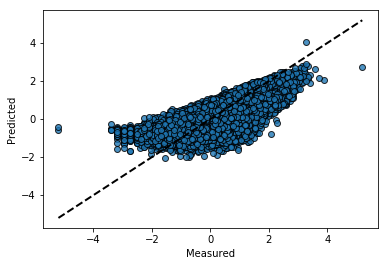

In [47]:
# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = cross_val_predict(linear_regressor, X, y, cv=5)

fig, ax   = plt.subplots()
ax.scatter(y, predicted, edgecolors=(0, 0, 0), alpha = 0.8)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
#ax.set_yscale('log')
#ax.set_xscale('log')                                                                                                
#ax.set_ylim([1, 200000])
#ax.set_xlim([1, 200000])
plt.show()


In [35]:
results = cross_val_score(linear_regressor, X_train, y_train, cv=10)
print(results)
print("mean: ", np.mean(results))


[0.55785084 0.57059437 0.56658185 0.58570192 0.5766387  0.57675566
 0.5835272  0.55263155 0.57027339 0.55450342]
('mean: ', 0.569505889640727)


### Learning curve

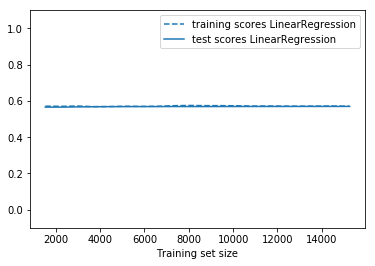

In [36]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(est, X, y):
    training_set_size, train_scores, test_scores = learning_curve(est, X, y, train_sizes=np.linspace(.1, 1, 20))
    estimator_name = est.__class__.__name__
    line = plt.plot(training_set_size, train_scores.mean(axis=1), '--', label="training scores " + estimator_name)
    plt.plot(training_set_size, test_scores.mean(axis=1), '-', label="test scores " + estimator_name, c=line[0].get_color())
    plt.xlabel('Training set size')
    plt.legend(loc='best')
    plt.ylim(-0.1, 1.1)

plt.figure()   
plot_learning_curve(LinearRegression(), X_train, y_train)


# Ridge Regression (L2 penalty)


In [37]:
# Create linear regression object
ridge_regressor = Ridge()

# Train the model using the training sets
ridge_regressor.fit(X_train, y_train)

# The coefficients
print('Coefficients: \n', ridge_regressor.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, ridge_regressor.predict(X_test)))
# Explained variance score: 1 is perfect prediction
print('R^2 (training): %f' % r2_score(y_train, ridge_regressor.predict(X_train)))
print('R^2 (testing): %f' % r2_score(y_test, ridge_regressor.predict(X_test)))

('Coefficients: \n', array([[ 0.08522612,  0.25671468, -0.13942566, -0.08908068,  0.08448738,
         0.18782752, -0.06391445, -0.01383224,  0.1151615 ,  0.15298775,
         0.25155397,  0.03848493,  0.0311131 ]]))
Mean squared error: 0.44
R^2 (training): 0.570687
R^2 (testing): 0.566136


### Tuning the hyperparameter alpha

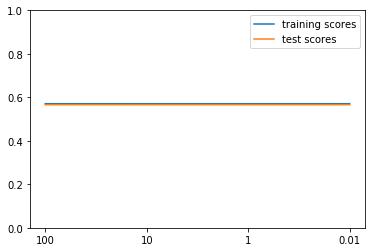

In [38]:
ridge_models = {}
training_scores = []
test_scores = []

for alpha in [100, 10, 1, .01]:
    ridge = Ridge(alpha=alpha).fit(X_train, y_train)
    training_scores.append(ridge.score(X_train, y_train))
    test_scores.append(ridge.score(X_test, y_test))
    ridge_models[alpha] = ridge

plt.figure()
plt.plot(training_scores, label="training scores")
plt.plot(test_scores, label="test scores")
plt.xticks(range(4), [100, 10, 1, .01])
plt.ylim([0,1])
plt.legend(loc="best")

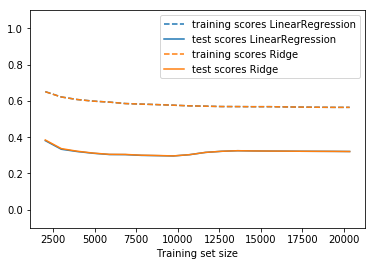

In [42]:
plt.figure()
plot_learning_curve(LinearRegression(), X, y)
plot_learning_curve(Ridge(alpha=10), X, y)

### Using GridSearchCV to set the best alpha 

In [40]:
from sklearn.model_selection import GridSearchCV
param_grid = {'alpha': np.logspace(-3, 3, 14)}
print(param_grid)

grid_search = GridSearchCV(Ridge(), param_grid, cv=10, return_train_score=True)
grid_search.fit(X_train, y_train)

print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))
print('Accuracy on the testing set: {:.4f}'.format(grid_search.best_estimator_.score(X_test, y_test)))

{'alpha': array([1.00000000e-03, 2.89426612e-03, 8.37677640e-03, 2.42446202e-02,
       7.01703829e-02, 2.03091762e-01, 5.87801607e-01, 1.70125428e+00,
       4.92388263e+00, 1.42510267e+01, 4.12462638e+01, 1.19377664e+02,
       3.45510729e+02, 1.00000000e+03])}
Test set score: 0.57
Best parameters: {'alpha': 41.246263829013564}
Best cross-validation score: 0.57
Best estimator:
Ridge(alpha=41.246263829013564, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)
Accuracy on the testing set: 0.5661


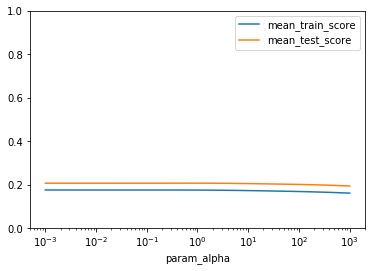

In [509]:
import pandas as pd
results = pd.DataFrame(grid_search.cv_results_)
results.plot('param_alpha', 'mean_train_score', ax=plt.gca())
results.plot('param_alpha', 'mean_test_score', ax=plt.gca())

plt.ylim([0,1])
plt.legend()
plt.xscale("log")

## Lasso (L1 penalty)

In [510]:
param_grid = {'alpha': np.logspace(-1.5, 0, 14)}

print(param_grid)

grid_search = GridSearchCV(Lasso(), param_grid, cv=10, return_train_score=True)
grid_search.fit(X_train, y_train)

print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))
print('Accuracy on the testing set: {:.4f}'.format(grid_search.best_estimator_.score(X_test, y_test)))

{'alpha': array([0.03162278, 0.04124626, 0.05379838, 0.07017038, 0.09152473,
       0.11937766, 0.15570684, 0.20309176, 0.26489693, 0.34551073,
       0.45065703, 0.58780161, 0.76668221, 1.        ])}


/home/milan/.local/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Test set score: 0.15
Best parameters: {'alpha': 0.1557068404753731}
Best cross-validation score: 0.21
Best estimator:
Lasso(alpha=0.1557068404753731, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
Accuracy on the testing set: 0.1534


# Robust models

In [286]:
 HuberRegressor, RANSACRegressor



(sklearn.linear_model.huber.HuberRegressor,
 sklearn.linear_model.ransac.RANSACRegressor)